# Data preparation 

Let's first only classify 30 dog breed from Standford dataset. 
Which are the one with the most images provided (number of images superior to the third inter-quartile)

https://www.youtube.com/watch?v=7Mv91hcxCCI&t=137s

In [305]:

%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import mlflow
# importing shutil module 
import shutil 
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
from common_params import data_dir, img_dir, npy_dir, MAX_NUMBER_CLASS, input_shape, image_size, IMG_SIZE
from common_plots import display_images
from common_mlflow import save_experiment_mlflow
from data_load import get_train_val_set, apply_data_augmentation, delete_files_in_directory, copy_files_from_dir, prepare_subfolder_extract

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
print(tf.__version__)

2.11.0


### Load images 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

##  DATASET SUBSET

In [332]:
model_run_config = {
    "experiment_name" : "cnn-dog-breed-classifier",
    "batch_size" : 32,
    "NB_IMG_PER_CLASS" : 200 ,
    "NB_CLASS" : 2 ,
    "num_epochs" : 40 ,
    "input_shape" : input_shape,
    "optimizer" : "adam",
    "metrics" : ['accuracy'],
    "loss" : "categorical_crossentropy",
    "num_augmentations" : 10,
    "data_augmentation" : True
    
}

In [308]:

batch_size              =  model_run_config['batch_size']
NB_IMG_PER_CLASS        =  model_run_config["NB_IMG_PER_CLASS"]
NB_CLASS                =  model_run_config["NB_CLASS"]
num_epochs              =  model_run_config["num_epochs"]
experiment_name         =  model_run_config["experiment_name"]
optimizer               =  model_run_config["optimizer"]
metrics                 =  model_run_config["metrics"]
loss                    =  model_run_config["loss"]
num_augmentations       =  model_run_config["num_augmentations"]
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)

# Add : only take NB_CLASS classes

In [309]:
train_dir, test_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

In [310]:
train_ds, validation_ds, class_names = get_train_val_set(train_dir, image_size, batch_size)



Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


In [311]:
class_names

['n02085936-Maltese_dog', 'n02088094-Afghan_hound']

<Figure size 700x700 with 0 Axes>

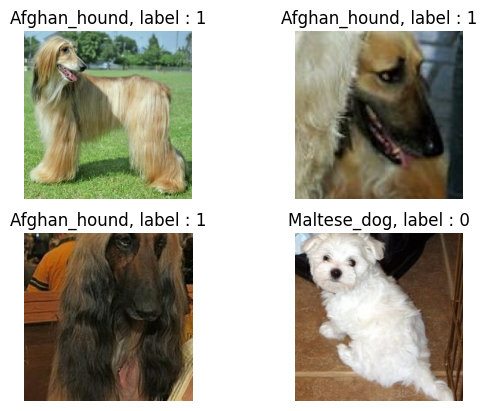

In [312]:
plt.figure(figsize=(7, 7))
img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

In [313]:
# train_ds, validation_ds = apply_data_augmentation(train_ds, validation_ds, num_augmentations )

<Figure size 700x700 with 0 Axes>

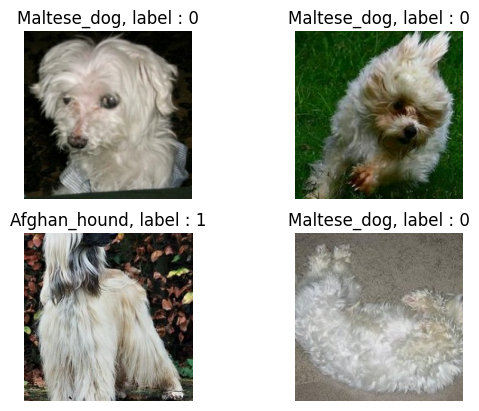

In [314]:
plt.figure(figsize=(7, 7))
img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

In [315]:
train_ds.cardinality().numpy() *32

160

# My convolutional neural network 

In [316]:
import keras_tuner as kt

In [317]:
model_run_config["conv1_width"] =  16 
model_run_config["conv2_width"] =  32
model_run_config["conv3_width"] =  64
model_run_config["dense1_size"] =  NB_CLASS*2

In [318]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling

def get_personal_model():
    model = Sequential()
    model.add(Rescaling( 1.0 / 255 , input_shape=input_shape))
    model.add(Conv2D(model_run_config["conv1_width"], (3, 3), activation='relu')) # kernel = 3*3
    model.add(MaxPooling2D((2, 2),strides=(2,2),padding="same"))
    
    model.add(Conv2D(model_run_config["conv2_width"] , (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(model_run_config["conv3_width"] , (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(model_run_config["dense1_size"], activation='relu'))
    
    model.add(Dropout(0.9))
    model.add(Dense(NB_CLASS, activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model 

In [319]:
cnn_based_model = get_personal_model()

In [320]:
cnn_based_model.build(input_shape)

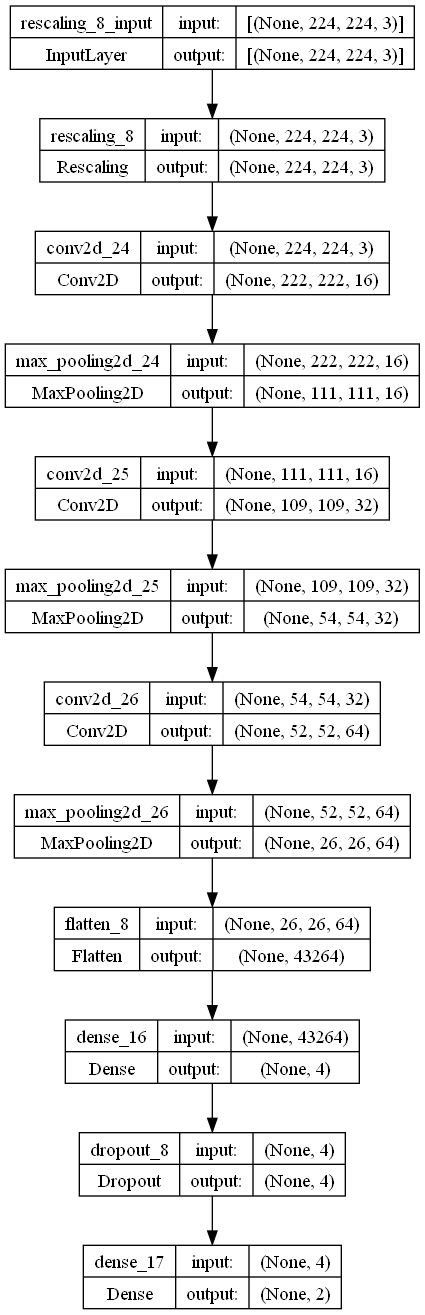

In [321]:
tf.keras.utils.plot_model(cnn_based_model, show_shapes=True)

In [322]:
cnn_based_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)      

In [323]:

run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tb_callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)]


In [324]:
os.path.isdir(logdir)

False

In [333]:
model_run_config["data_augmentation"]

True

In [335]:
if model_run_config["data_augmentation"] : 
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2)
    td = datagen.flow(train_ds)
else :
    td = train_ds


TypeError: float() argument must be a string or a number, not 'MapDataset'

In [325]:


history = cnn_based_model.fit(
    td,
    epochs=num_epochs,
    callbacks=tb_callback,
    validation_data=validation_ds)

Epoch 1/40
5/5 [==============================] - 3s 431ms/step - loss: 0.7097 - accuracy: 0.4688 - val_loss: 0.6932 - val_accuracy: 0.4250
Epoch 2/40
5/5 [==============================] - 2s 374ms/step - loss: 0.6934 - accuracy: 0.5125 - val_loss: 0.6938 - val_accuracy: 0.4250
Epoch 3/40
5/5 [==============================] - 2s 374ms/step - loss: 0.6931 - accuracy: 0.5188 - val_loss: 0.6940 - val_accuracy: 0.4250
Epoch 4/40
5/5 [==============================] - 2s 377ms/step - loss: 0.6930 - accuracy: 0.5188 - val_loss: 0.6941 - val_accuracy: 0.4250
Epoch 5/40
5/5 [==============================] - 2s 384ms/step - loss: 0.6929 - accuracy: 0.5188 - val_loss: 0.6942 - val_accuracy: 0.4250
Epoch 6/40
5/5 [==============================] - 2s 387ms/step - loss: 0.6929 - accuracy: 0.5188 - val_loss: 0.6943 - val_accuracy: 0.4250
Epoch 7/40
5/5 [==============================] - 2s 382ms/step - loss: 0.6929 - accuracy: 0.5188 - val_loss: 0.6945 - val_accuracy: 0.4250
Epoch 8/40
5/5 [====

In [326]:
save_experiment_mlflow(cnn_based_model, model_run_config, run_name, history)

MLFlow Run ID:  f002a1376a1547be9f5d9564c5a04994


INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmp342yv9v9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmp342yv9v9\model\data\model\assets


In [327]:
from common_plots import plot_train_val_accuracy_and_loss

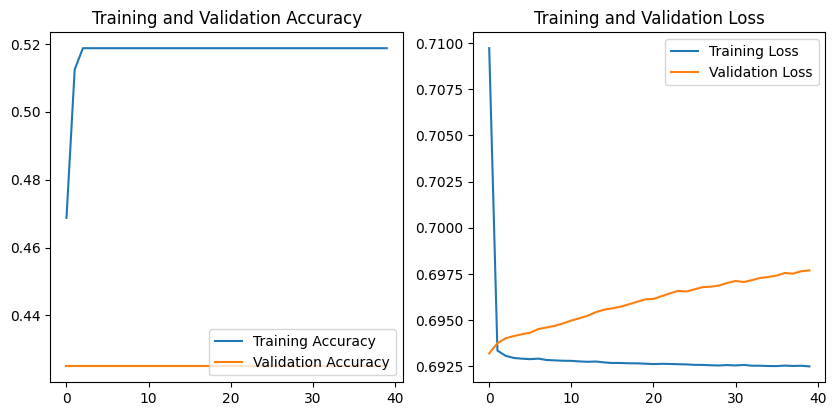

In [328]:
plot_train_val_accuracy_and_loss(history)

In [329]:
img_path = os.path.join(data_dir,"extracted\\test\\n02085936-Maltese_dog\\n02085936_1244_0.jpg")
img = tf.keras.utils.load_img(
    img_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = cnn_based_model.predict(img_array)[0]
print(predictions)


1/1 [==============================] - 0s 94ms/step
[0.48612377 0.5138762 ]


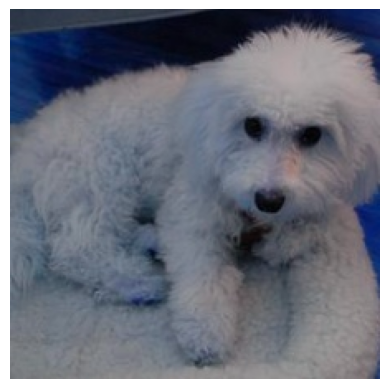

In [330]:
plot_img_from_path(img_path)

In [331]:
class_names_from_folder = [ name.split('-')[1] for name in class_names ]
print(f"This image as a probability {round(100*predictions[0],2)}% {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

This image as a probability 48.61% Maltese_dog of and a probability 51.39% of Afghan_hound
